# Hire-Gutnisky-2015 - A DataJoint example
This notebook presents data and results associated with the following papers:
>Samuel Andrew Hires, Diego A Gutnisky, Jianing Yu, Daniel H O’Connor, and Karel Svoboda. "Low-noise encoding of active touch by
layer 4 in the somatosensory cortex" (2015) eLife (http://doi.org/10.7554/eLife.06619)

Original data shared here: http://crcns.org/data-sets/ssc/ssc-5/about-ssc-5

The data in original MATLAB format (.mat) have been ingested into a DataJoint data pipeline presented below. This notebook demonstrates the queries, processing, and reproduction of several figures from the paper. 

Data are also exported into NWB 2.0 format. See NWB export code [here](../scripts/datajoint_to_nwb.py)

In [1]:
from datetime import datetime
import os
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datajoint as dj
from pipeline import (reference, subject, acquisition, stimulation, analysis, virus,
                      intracellular, extracellular, behavior, utilities)

Connecting root@127.0.0.1:3306


In [2]:
import warnings
warnings.filterwarnings('ignore')

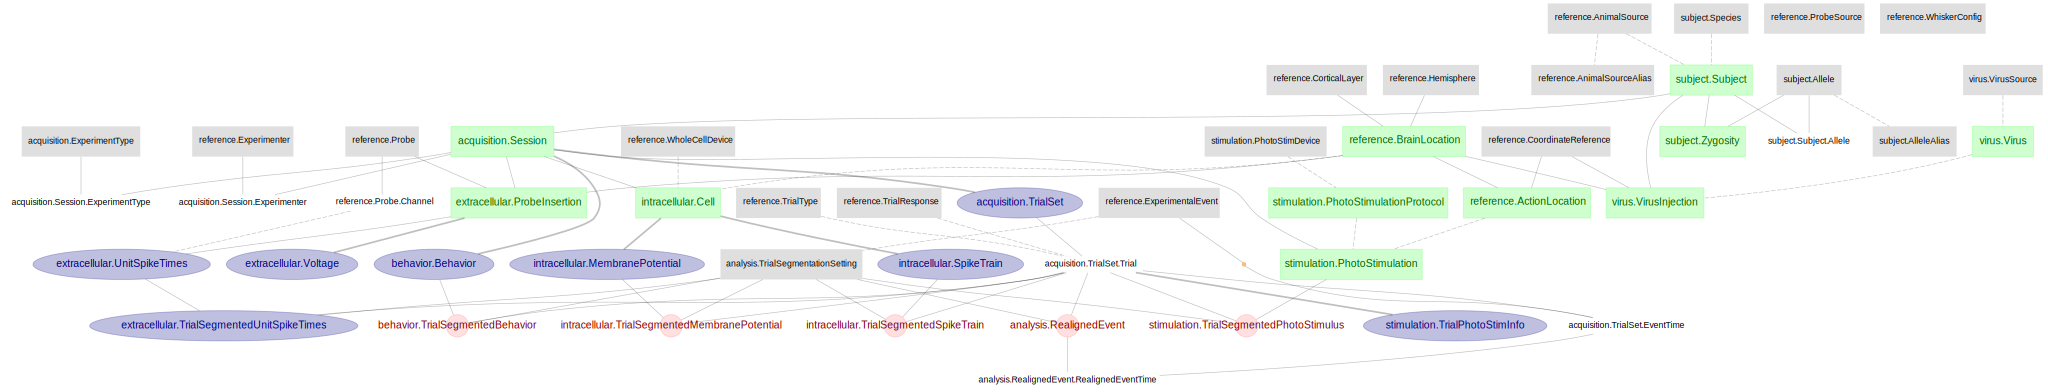

In [3]:
all_erd = (dj.ERD(reference) + dj.ERD(subject) + dj.ERD(virus)
           + dj.ERD(acquisition) + dj.ERD(analysis)
           + dj.ERD(stimulation) + dj.ERD(behavior)
           + dj.ERD(extracellular) + dj.ERD(intracellular))
dj.ERD(all_erd)

## Reproducing Figure 1B, C, E

### Select an example cell recording session - "Cell 23"

In [4]:
session_key = acquisition.Session & 'session_id="Cell23"'

In [5]:
trial_key = acquisition.TrialSet.Trial & session_key & 'trial_id=78'

In [6]:
# Specify segmentation setting to align to "trial_start" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'trial_start',
                                                      'pre_stim_duration': 0,
                                                      'post_stim_duration': 4.9}).fetch1()

### Figure 1A

In [7]:
# Get segmented Membrane Potential and Spike Train
mp, ephys_timestamps = (intracellular.TrialSegmentedMembranePotential & trial_key & seg_param_key).fetch1('segmented_mp', 'segmented_mp_timestamps')
behav = (behavior.TrialSegmentedBehavior & trial_key & seg_param_key).fetch1()
behav_timestamps = behav['segmented_behavior_timestamps']

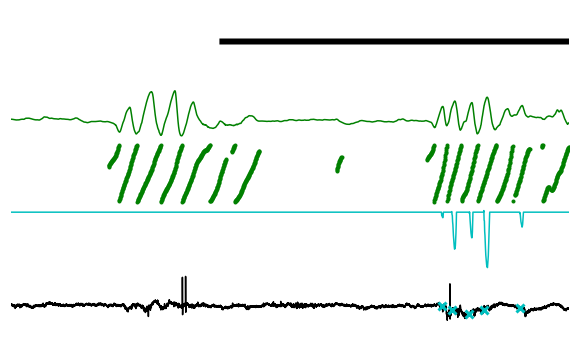

In [8]:
fig1a, axs = plt.subplots(5, 1, figsize=(10, 6))
fig1a.subplots_adjust(hspace=0.05)
axs[0].plot(behav_timestamps, np.where(behav['segmented_pole_available'] > 0, behav['segmented_pole_available'], np.nan), 'k',
           linewidth=6)
axs[1].plot(behav_timestamps, behav['segmented_theta_at_base'], 'g')
axs[2].plot(behav_timestamps, np.where(behav['segmented_amplitude'] > 2.5, behav['segmented_phase'], np.nan), '.g')
axs[3].plot(behav_timestamps, behav['segmented_delta_kappa'], 'c')
axs[4].plot(ephys_timestamps, mp, 'k')
axs[4].plot(behav_timestamps, np.where(behav['segmented_touch_onset'] == 1, mp[::10][:-1], np.nan), 'xc', 
            markeredgewidth=3, markersize=8)
for a in axs:
    a.set_xlim((0, 2))
    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)
    a.spines['left'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.set_xticks([])
    a.set_yticks([])

### Figure 1C, D

In [9]:
# get spike-train
spk, spk_timestamps = (intracellular.TrialSegmentedSpikeTrain & session_key & seg_param_key).fetch(
    'segmented_spike_train', 'segmented_spike_timestamps')

In [10]:
# restructure data for spike raster  
trial_idx, spike_times = zip(*((np.full_like(r, ri), r)
                                        for ri, r in enumerate(t[np.where(r > 0)[0]] for r, t in zip(spk, spk_timestamps))))
trial_idx = np.hstack(trial_idx)
spike_times = np.hstack(spike_times) 

In [11]:
# trial-average spike histogram
def build_PSTH(spike_train, timestamps, tlim, bin_size=0.05):
    spk_counts, spk_edges = np.histogram(np.hstack(t[np.where(r[:len(t)] > 0)[0]] 
                                                   for r, t in zip(spike_train, timestamps)),
                                                   bins=int((tlim[-1] - tlim[0]) / bin_size), range=tlim)
    spk_rates = spk_counts / np.diff(spk_edges) / len(spike_train)
    return spk_rates, spk_edges[:-1]

In [12]:
tlim = -float(seg_param_key['pre_stim_duration']), float(seg_param_key['post_stim_duration'])
spk_rates, spk_edges = build_PSTH(spk, spk_timestamps, tlim, bin_size=0.05)

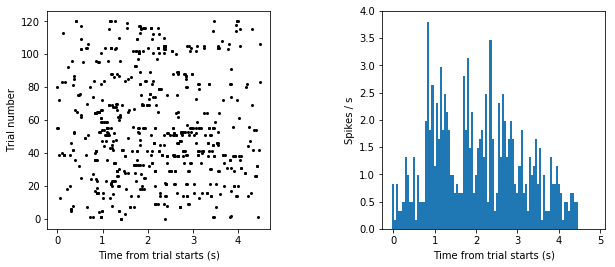

In [13]:
fig1cd, ax = plt.subplots(1, 2, figsize=(10, 4))
fig1cd.subplots_adjust(wspace=0.5)
ax[0].plot(spike_times, trial_idx , '.k', markersize=4)
ax[1].bar(spk_edges, spk_rates, width=0.05);
ax[0].set_ylabel('Trial number')
ax[0].set_xlabel('Time from trial starts (s)')
ax[1].set_xlabel('Time from trial starts (s)')
ax[1].set_ylabel('Spikes / s');

### Figure 1E, F

In [14]:
# Specify segmentation setting to align to "first lick" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'first_lick',
                                                      'pre_stim_duration': 1,
                                                      'post_stim_duration': 4}).fetch1()

In [15]:
# get spike-train
spk, spk_timestamps = (intracellular.TrialSegmentedSpikeTrain & session_key & seg_param_key).fetch(
    'segmented_spike_train', 'segmented_spike_timestamps')
touchon = (behavior.TrialSegmentedBehavior & session_key & seg_param_key).fetch('segmented_touch_onset')
ephys_timestamps = np.linspace(-1*float(seg_param_key['pre_stim_duration']),
                               float(seg_param_key['post_stim_duration']),
                               spk[0].size)

In [16]:
# get touch duration (last-touch - first-touch)
touch_dur = [np.diff(np.where(r > 0)[0][[0, -1]])[0] if np.where(r > 0)[0].size > 0 else -1 for r in touchon]

In [17]:
# sort trials based on touch duration
spk = spk[np.argsort(touch_dur)]

In [18]:
# restructure data for spike raster  
trial_idx, spike_times = zip(*((np.full_like(r, ri), r)
                                        for ri, r in enumerate(t[np.where(r > 0)[0]] for r, t in zip(spk, spk_timestamps))))
trial_idx = np.hstack(trial_idx)
spike_times = np.hstack(spike_times) 

In [19]:
tlim = -float(seg_param_key['pre_stim_duration']), float(seg_param_key['post_stim_duration'])
spk_rates, spk_edges = build_PSTH(spk, spk_timestamps, tlim, bin_size=0.001)

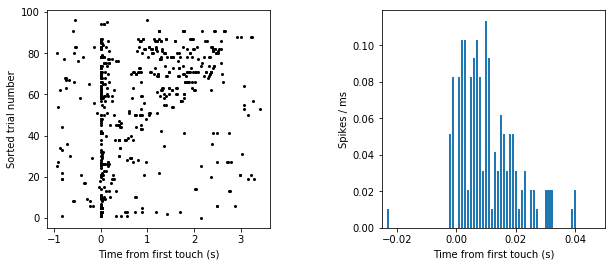

In [20]:
fig1ef, ax = plt.subplots(1, 2, figsize=(10, 4))
fig1ef.subplots_adjust(wspace=0.5)
ax[0].plot(spike_times, trial_idx , '.k', markersize=4)
ax[0].set_ylabel('Sorted trial number')
ax[0].set_xlabel('Time from first touch (s)')
ax[1].bar(spk_edges, spk_rates / 1000, width=0.0007);
ax[1].set_xlim((-0.025, 0.05));
ax[1].set_xlabel('Time from first touch (s)')
ax[1].set_ylabel('Spikes / ms');

## Figure 2 - Population

### Get recordings of cell population in categories:
+ L4 C2-inside
+ L4 C2-outside
+ L5 C2-inside

In [21]:
l4_c2_inside_sess = intracellular.Cell & {'brain_subregion': 'C2', 'cortical_layer': 4}
l4_c2_outside_sess = intracellular.Cell & {'brain_subregion': 'surround', 'cortical_layer': 4}
l5_c2_inside_sess = intracellular.Cell & {'brain_subregion': 'C2', 'cortical_layer': 5}

In [22]:
print(f'Number of L4 C2-inside cells: {len(l4_c2_inside_sess)}')
print(f'Number of L4 C2-outside cells: {len(l4_c2_outside_sess)}')
print(f'Number of L5 C2-inside cells: {len(l5_c2_inside_sess)}')

Number of L4 C2-inside cells: 31
Number of L4 C2-outside cells: 10
Number of L5 C2-inside cells: 11


### Prepare to plot figure 2A
Population mean PSTH for 3 unit groups fetched above, aligned to the onset of `pole move in`

***Note***: this is slightly different from Figure 2A in the paper, in which data are aligned to `pole available`

In [23]:
# Specify segmentation setting to align to "pole in" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'pole_in',
                                                      'pre_stim_duration': 0.5,
                                                      'post_stim_duration': 3}).fetch1()

In [24]:
# get spike-train from all trials from all cells - population level
l4_c2_inside_spk, l4_c2_inside_times = (intracellular.TrialSegmentedSpikeTrain & l4_c2_inside_sess & seg_param_key).fetch(
    'segmented_spike_train', 'segmented_spike_timestamps')
l4_c2_outside_spk, l4_c2_outside_times = (intracellular.TrialSegmentedSpikeTrain & l4_c2_outside_sess & seg_param_key).fetch(
    'segmented_spike_train', 'segmented_spike_timestamps')
l5_c2_inside_spk, l5_c2_inside_times = (intracellular.TrialSegmentedSpikeTrain & l5_c2_inside_sess & seg_param_key).fetch(
    'segmented_spike_train', 'segmented_spike_timestamps')

In [25]:
tlim = -float(seg_param_key['pre_stim_duration']), float(seg_param_key['post_stim_duration'])

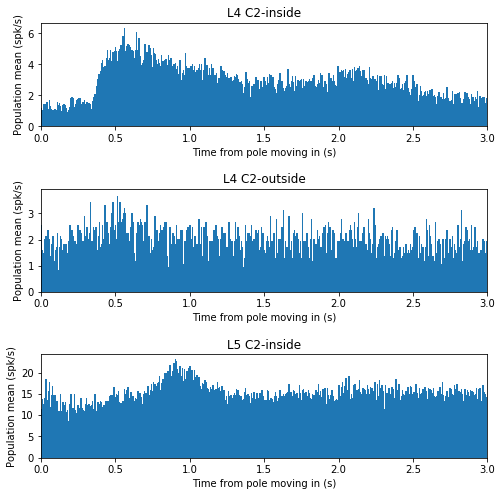

In [26]:
fig2a, axs = plt.subplots(3, 1, figsize=(8, 8))
fig2a.subplots_adjust(hspace=0.6)
for ax, spike_train, timestamps, title in zip(axs, (l4_c2_inside_spk, l4_c2_outside_spk, l5_c2_inside_spk),
                                              (l4_c2_inside_times, l4_c2_outside_times, l5_c2_inside_times),
                                              ('L4 C2-inside', 'L4 C2-outside', 'L5 C2-inside')):
    spk_rates, spk_edges = build_PSTH(spike_train, timestamps, tlim, bin_size=0.006)
    ax.bar(spk_edges, spk_rates, width=0.01)
    ax.set_xlim((0, 3))
    ax.set_title(title);
    ax.set_ylabel('Population mean (spk/s)')
    ax.set_xlabel('Time from pole moving in (s)');

### Prepare to plot figure 2B

Peri-stimulus time histogram aligned to `first touch`. Trial-segmented spikes aligned to `trial start` are precomputed, this data are fetched and realigned to `first touch`. 

In [27]:
# trial-average spike histogram
def build_realigned_PSTH(spike_train, spk_timestamps, event_data, event_timestamps, timerange, tlim, bin_size=0.05):
    spike_times = []
    for spikes, spk_t, events, event_t in zip(spike_train, spk_timestamps, event_data, event_timestamps):
        if (events > 0).any():
            first_eve = event_t[events == 1][0]
            aligned_spk = (spk_t - first_eve)[spikes > 0] 
            spike_times.append(aligned_spk)
    
    if spike_times:
        spk_counts, spk_edges = np.histogram(np.hstack(spike_times),
                                             bins=int((tlim[-1] - tlim[0]) / bin_size), range=tlim)
        spk_rates = spk_counts / np.diff(spk_edges) / len(spike_times)
        spk_edges = spk_edges[1:] 
        
        # normalize
        spk_rates = spk_rates / np.nanmax(spk_rates)
        
        return spk_rates, spk_edges
    else:
        return None, None

In [28]:
# Specify segmentation setting to align to "trial_start" event
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'trial_start',
                                                      'pre_stim_duration': 0,
                                                      'post_stim_duration': 4.9}).fetch1()

In [29]:
# get spike-train from all trials from all cells - population level
l4_c2_inside_spk = [(intracellular.TrialSegmentedSpikeTrain * behavior.TrialSegmentedBehavior & s & seg_param_key).fetch(
    'segmented_spike_train', 'segmented_spike_timestamps', 'segmented_touch_onset', 'segmented_behavior_timestamps')
                    for s in l4_c2_inside_sess.fetch('KEY', order_by='session_id')]
l4_c2_outside_spk = [(intracellular.TrialSegmentedSpikeTrain * behavior.TrialSegmentedBehavior & s & seg_param_key).fetch(
    'segmented_spike_train', 'segmented_spike_timestamps', 'segmented_touch_onset', 'segmented_behavior_timestamps')
                     for s in l4_c2_outside_sess.fetch('KEY', order_by='session_id')]
l5_c2_inside_spk = [(intracellular.TrialSegmentedSpikeTrain * behavior.TrialSegmentedBehavior & s & seg_param_key).fetch(
    'segmented_spike_train', 'segmented_spike_timestamps', 'segmented_touch_onset', 'segmented_behavior_timestamps')
                    for s in l5_c2_inside_sess.fetch('KEY', order_by='session_id')]

In [30]:
tlim=(-0.025, 0.05)
population_psth = []
cell_spk_edge = None
for unit_group in (l4_c2_inside_spk, l4_c2_outside_spk, l5_c2_inside_spk):
    # compute PSTH for population level
    PSTH_matrix = [build_realigned_PSTH(spk_train, spk_times, touch_onsets, behav_times, timerange=(-1*float(seg_param_key['pre_stim_duration']),
                               float(seg_param_key['post_stim_duration'])), tlim=tlim, bin_size=0.0005)
                   for spk_train, spk_times, touch_onsets, behav_times in unit_group if spk_train.size > 0]

    # obtain unit psth
    cell_spk_edge = PSTH_matrix[0][1] if cell_spk_edge is None else cell_spk_edge
    # per-unit normalization
    cell_spk_rate = np.vstack([s[0] for s in PSTH_matrix]) 
    # sort units based on response amplitude
#     sorted_units = np.argsort(np.argmax(cell_spk_rate, axis=1))
#     cell_spk_rate = cell_spk_rate[sorted_units, :]
    population_psth.append(cell_spk_rate)
    population_psth.append(np.full((1, cell_spk_rate.shape[1]), np.nan))

In [31]:
population_psth = np.vstack(population_psth)

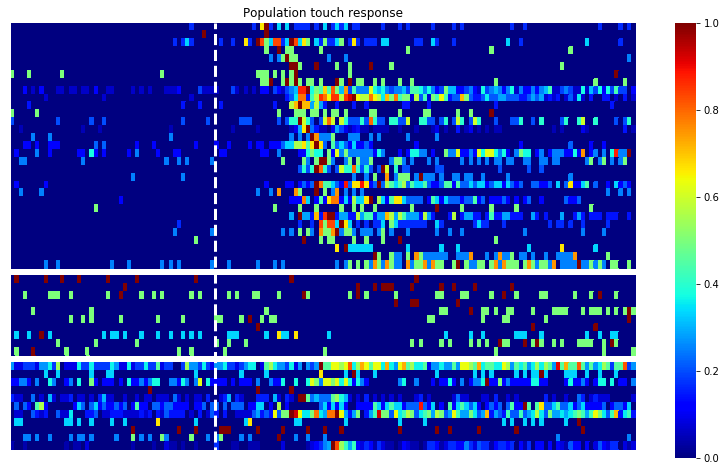

In [32]:
fig2b, ax = plt.subplots(1, 1, figsize=(14, 8))
sns.heatmap(population_psth, cmap='jet', ax=ax, xticklabels=[], yticklabels=[])

ax.axvline(x=np.where(np.abs(cell_spk_edge-0)<1e-15)[0][0], color='w',linestyle='--',linewidth=3)
ax.set_title('Population touch response');